# Dependencies

In [1]:
import random
import copy
import torch
from torch import nn

from dotmap import DotMap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.utils.validation import check_random_state
from tensor_completion_models.utils import *

import tensorly as tl
from tensorly.decomposition import non_negative_parafac_hals as nnp_hals

# Data

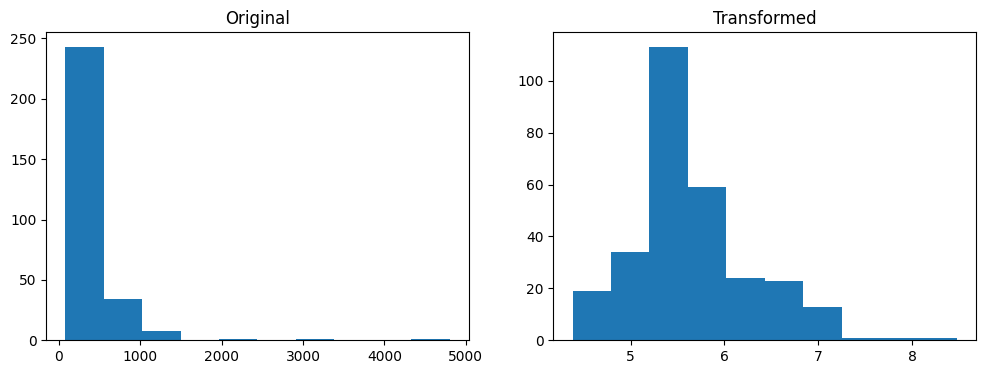

Tensor shape: [np.int64(35), np.int64(23), np.int64(22), np.int64(22), np.int64(3)]
288 samples.


In [ ]:
data_folder = 'data/'

dataset = 'lattice'
# dataset = 'crossed_barrel'
# dataset = 'cogni_spin'

if dataset == 'lattice':
    df = pd.read_csv(f'{data_folder}database_latticedesign.csv')
    features = ['lattice_type', 't', 'uc_x1', 'uc_x2', 'uc_x3']
    lattice_names = dict(zip(df["lattice_type"], df["lattice_name"]))

    targets = [
        # 'E (MPa)',
        'E_specific (MPa/g)'
        ]

    if len(targets) > 1:
        df_list = list()
        for ti in range(len(targets)): 
            sub_df = df[features + [targets[ti]]].to_numpy()
            sub_df = np.concatenate((ti*np.ones((sub_df.shape[0], 1)), 
                                    sub_df), 
                                    axis = 1)

            df_list.append(sub_df)

        target = 'target'
        df = pd.DataFrame(np.concatenate(df_list), columns = ['task'] + features + [target])
        features = [x for x in list(df.columns) if x != target]
    else:
        target = targets[0]
        df = df[features + [target]]

elif dataset == 'crossed_barrel':
    df = pd.read_csv(f'{data_folder}crossed_barrel_dataset_v2.csv')
    features = ['n', 'theta', 'r', 't']
    targets = ['toughness']
    target = targets[0]
    df = df[features + [target]]
    df = df.groupby(features, as_index=False).agg(target=(target, 'median'))
    target = 'target'

    
elif dataset.lower() == 'cogni_spin':
    df = pd.read_csv(f'{data_folder}Cogni-e-SpinDB 1.0.csv')

    features = ['solution_concentration', 'voltage_kv', 'flow_rate_ml/h', 'tip_collector_distance_cm',
                'polymer(s)']
    # features += ['needle_diameter_g']  # ~50% missing values!

    target = 'fiber_diameter_nm'

    df = df[df['polymer(s)'].map(lambda x: x in ['PVDF', 'PVA', 'PAN'])]
    codes, uniques = pd.factorize(df["polymer(s)"])
    df['polymer(s)'] = codes

    df = df[features + [target]].dropna()

    mask = (df['flow_rate_ml/h'] < 5) & (df['tip_collector_distance_cm'] < 45) & (df['voltage_kv'] < 40)
    df = df[mask]
    
df = (
    df.groupby(features, as_index=False)
    .agg(
        value_mean=(target, 'mean'),
        target_std=(target, 'std'),
        target_min=(target, 'min'),
        target_max=(target, 'max'),
        num_duplicates=(target, 'count')
    )
)

df['target_std'] = df['target_std'].fillna(0)
df.columns = [x if x != 'value_mean' else target for x in df.columns]
df = df[df.columns[:-4]]


fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df[target])
axes[0].set_title('Original', fontsize = 12)

axes[1].hist(np.log(df[target]))
axes[1].set_title('Transformed', fontsize = 12)

plt.show()

df[target] = np.log(df[target])

round_ = None

if type(round_) in [float, int]: round_ = {feature:round_ for feature in features}
elif round_ is not None:
    for feature in features:
        if feature not in round_: round_[feature] = round_['default']
tensor_df = df.copy()
master_conv, r_master_conv = dict(), dict()
for feature in features:
    if round_ is not None: unique = (tensor_df[feature]//round_[feature]).unique()
    else: unique = tensor_df[feature].unique()
    unique = np.sort(unique)
    conv = {unique[i]:i for i in range(len(unique))}
    master_conv[feature] = conv
    r_conv = {i:unique[i] for i in range(len(unique))}
    r_master_conv[feature] = r_conv
    if round_ is not None: tensor_df[feature] = (tensor_df[feature]//round_[feature]).map(lambda x: conv[x])
    else: tensor_df[feature] = tensor_df[feature].map(lambda x: conv[x])

tensor_shape = torch.Size([tensor_df[feature].max()+1 for feature in features])
print(f"Tensor shape: {list(tensor_shape)}\n{tensor_df.shape[0]} samples.")

indices = tensor_df[features].to_numpy()
indices = torch.tensor(indices, dtype = torch.int32)
values = torch.tensor(tensor_df[target].to_numpy())

values = (values - values.min()) / (values.max() - values.min())

sparse_tensor = torch.sparse_coo_tensor(indices = indices.t(), values = values, 
                                        size = tensor_shape
                                       ).coalesce()

def one_hot_encode(df, col):
    dummies = pd.get_dummies(df[col], prefix=col)
    r_df = pd.concat([dummies.astype(int), df.drop(columns=[col])], axis=1)
    r_df = r_df[[c for c in r_df.columns if c != target] + [target]]
    return r_df

if dataset == 'lattice': df = one_hot_encode(df, 'lattice_type')
tensor_features = copy.deepcopy(features)
features = [x for x in df.columns if x != target]

# Experiment

In [3]:
rank = 3

# lambda_start = [1e-5, (2700, None)]
lambda_start = [0, (-1, -1)]

# smooth_lambda = 5e-1
smooth_lambda = 0

train_size = 0.8
random_state = int(100_000 * random.random())

### Things

In [4]:
# tl.set_backend("pytorch")

# nnp_weights, nnp_factors = nnp_hals(sparse_tensor.to_dense(), rank = rank, normalize_factors = False,
#                                     n_iter_max = 250, init = 'random',
#                                     random_state = random_state)

In [5]:
class CPD(nn.Module):

    def __init__(self, cfg):
        super(CPD, self).__init__()

        self.cfg = cfg
        self.rank = cfg.rank
        self.sizes = cfg.sizes
        self.nmode = len(self.sizes)

        self.embeds = nn.ModuleList([nn.Embedding(self.sizes[i], self.rank)
                                     for i in range(len(self.sizes))])

        self.smooth_lambda = cfg.smooth_lambda
        self.window = cfg.window
        self.smooth = Kernel(self.window, density = None).to(device)
        self.non_smooth_modes = cfg.non_smooth_modes

        self._initialize()

    def _initialize(self):
        rng = check_random_state(self.cfg.random)
        for m in range(self.nmode):
            self.embeds[m].weight.data = torch.tensor(rng.random_sample((self.sizes[m], self.rank)))
            # self.embeds[m].weight.data = nnp_factors[m]

    def recon(self, idxs):
        facs = [self.embeds[m](idxs[:, m]).unsqueeze(-1) for m in range(self.nmode)]
        concat = torch.concat(facs, dim=-1)
        rec = torch.prod(concat, dim=-1)
        return rec.sum(-1)

    def forward(self, idxs):
        return self.recon(idxs)

    def smooth_reg(self, mode):
        ''' Perform a smoothing regularization on the factor '''

        smoothed = self.smooth(self.embeds[mode].weight)        
        sloss = abs(smoothed - self.embeds[mode].weight).pow(1)

        return sloss.mean()

    def get_inner_prod_loss(self):
        factors_loss = 0
        for f in range(self.nmode):
            factor = self.embeds[f]

            factor_loss = 0
            n_vecs = factor.weight.shape[0]
            for i in range(n_vecs):
                for j in range(n_vecs):
                    if i == j: continue
                    inner_prod = factor.weight[i] @ factor.weight[j]
                    factor_loss += inner_prod

            factors_loss += factor_loss
        return factors_loss

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(sparse_tensor.indices().t(), 
                                                    sparse_tensor.values(), 
                                                    train_size = train_size, 
                                                    shuffle = True, 
                                                    random_state = random_state)

In [7]:
cfg = DotMap({
    'rank':rank, 
    'sizes':sparse_tensor.size(),
    'random':int(100_000 * random.random()),
    'lr':1e-3,
    'wd':1e-4,
    'epochs':3000,

    'smooth_lambda':smooth_lambda,
    'window':3,
    'non_smooth_modes':[0, 4],

    'dropout':0.1,
    'dropout2':0.5,
    'layer_dims':(len(sparse_tensor.size()), 16, 1),
    'depth':3,
    'act':'',
    'device':'cpu',

    })

# model = NeAT(cfg)
model = CPD(cfg)

# loss_fn = lambda y, yhat: ( abs(y - yhat) ** 2 ).mean()
loss_fn = lambda y, yhat: abs(y - yhat).mean()
optimizer = torch.optim.Adam(model.parameters(), 
                             lr = cfg.lr, weight_decay = cfg.wd)

for n_epoch in range(1, cfg.epochs+1):

    if lambda_start[1][0] is None and lambda_start[1][1] is None: lambda_ = lambda_start[0]
    elif lambda_start[1][0] is None: lambda_ = 0 if n_epoch >= lambda_start[1][1] else lambda_start[0]
    elif lambda_start[1][1] is None: lambda_ = 0 if n_epoch <= lambda_start[1][0] else lambda_start[0]
    else: lambda_ = 0 if not (n_epoch <= lambda_start[1][1] and n_epoch >= lambda_start[1][0]) else lambda_start[0]

    model.train()
    optimizer.zero_grad()
    values = Y_train
    rec = model(X_train)

    reg_loss = (1 - lambda_) * loss_fn(values, rec) 
    # factors_loss = lambda_ * model.get_inner_prod_loss()
    factors_loss = 0
    
    smooth_loss = 0
    for n in range(len(model.sizes)):    
        if n not in model.non_smooth_modes:                
            smooth_loss = smooth_loss + model.smooth_reg(n)
    smooth_loss += model.smooth_lambda

    loss = reg_loss + factors_loss + smooth_loss

    loss.backward()
    optimizer.step()

    f = lambda x, y = 4: (' ' * (y - len(str(x)))) + str(x)
    if not n_epoch % 100: print(f"Epoch {f(n_epoch)} | loss = {loss:.6f} ({reg_loss:.6f} + {factors_loss:.6f} + {smooth_loss:.6f}) | λ = {lambda_}")

Epoch  100 | loss = 0.289708 (0.160245 + 0.000000 + 0.129463) | λ = 0
Epoch  200 | loss = 0.196581 (0.115693 + 0.000000 + 0.080888) | λ = 0
Epoch  300 | loss = 0.129440 (0.078892 + 0.000000 + 0.050549) | λ = 0
Epoch  400 | loss = 0.094461 (0.062846 + 0.000000 + 0.031615) | λ = 0
Epoch  500 | loss = 0.078543 (0.056017 + 0.000000 + 0.022526) | λ = 0
Epoch  600 | loss = 0.070712 (0.051736 + 0.000000 + 0.018976) | λ = 0
Epoch  700 | loss = 0.065485 (0.047422 + 0.000000 + 0.018063) | λ = 0
Epoch  800 | loss = 0.060141 (0.042200 + 0.000000 + 0.017940) | λ = 0
Epoch  900 | loss = 0.054787 (0.036859 + 0.000000 + 0.017928) | λ = 0
Epoch 1000 | loss = 0.051523 (0.034307 + 0.000000 + 0.017216) | λ = 0
Epoch 1100 | loss = 0.049070 (0.032205 + 0.000000 + 0.016864) | λ = 0
Epoch 1200 | loss = 0.047731 (0.031339 + 0.000000 + 0.016392) | λ = 0
Epoch 1300 | loss = 0.046655 (0.030771 + 0.000000 + 0.015884) | λ = 0
Epoch 1400 | loss = 0.045774 (0.030386 + 0.000000 + 0.015388) | λ = 0
Epoch 1500 | loss = 

In [8]:
preds = model(X_test).detach()
r2 = r2_score(Y_test, preds)
r, pv = pearsonr(Y_test, preds)

def parity_plot():

    plt.figure(figsize=(10, 6))
    plt.scatter(Y_test, preds, color = 'limegreen', edgecolors = 'black')

    min_val = min(Y_test.min(), preds.min())
    max_val = max(Y_test.max(), preds.max())
    plt.plot([min_val, max_val], [min_val, max_val], color = 'black', linestyle="-", lw = 2, zorder = 0)

    plt.xlabel("True values", fontsize = 16)
    plt.ylabel("Predicted values", fontsize = 16)

    textstr = (
        f"R² = {r2:.3f}\nr = {r:.3f}"
    )

    plt.text(
        0.21, 0.96, textstr,
        transform=plt.gca().transAxes,
        fontsize=20,
        verticalalignment="top",
        horizontalalignment="right",
        bbox=dict(
            boxstyle="round,pad=0.3",
            facecolor="white",
            edgecolor="black",
        )
    )

    plt.tight_layout()
    plt.show()

### Parity Plot

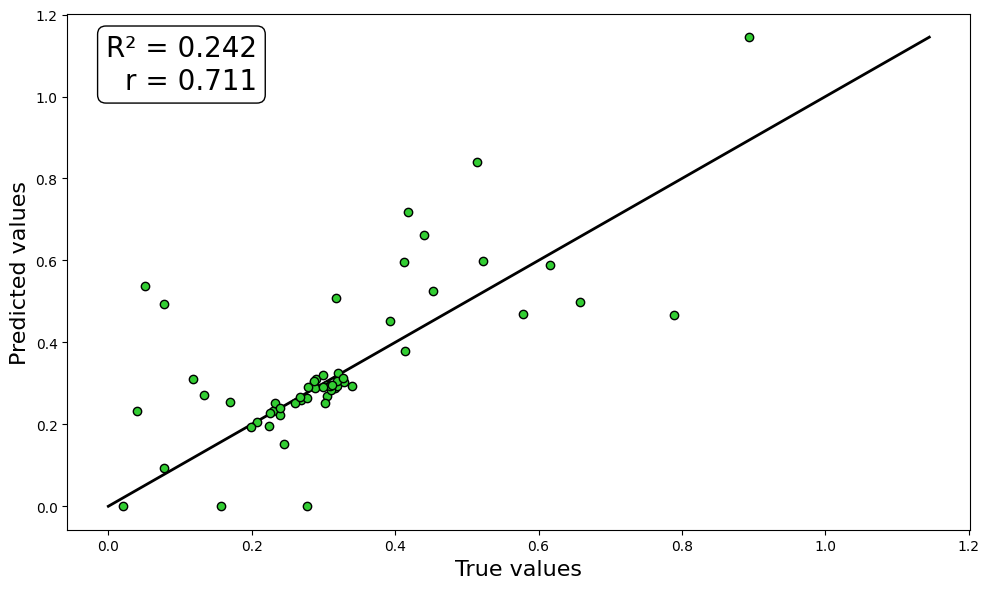

In [9]:
parity_plot()

In [10]:
pred_indices = torch.concat((X_train, X_test)).t()
pred_values = torch.concat((Y_train, preds))

predicted_sparse_tensor = torch.sparse_coo_tensor(indices = pred_indices, 
                                                  values = pred_values, 
                                                  size = sparse_tensor.size()
                                                 ).coalesce()

In [61]:
import matplotlib.patches as patches

def plot_factor_components(factor_i, factor_list, rank, highlight_bars = False):
    arr = factor_list[factor_i].numpy()
    n_groups, n_bars = arr.shape

    x = np.arange(n_groups)
    width = 1/(rank+1)

    plt.figure(figsize=(10, 5))

    for j in range(n_bars): plt.bar(x + j*width, arr[:, j], width=width, label=f'Component {j+1}')

    if dataset == 'lattice' and factor_i == len(targets)-1: x_tick_labels = [f'{lattice_names[i]}' for i in range(n_groups)]
    elif dataset == 'lattice' and factor_i > 1: x_tick_labels = [f'{r_master_conv[tensor_features[factor_i]][i]}mm' for i in range(n_groups)]
    elif dataset == 'cogni_spin' and factor_i == 4: x_tick_labels = list(uniques)
    else: x_tick_labels = [f'{r_master_conv[tensor_features[factor_i]][i]}' for i in range(n_groups)]
    plt.xticks(x + width*(n_bars-1)/2, x_tick_labels, fontsize = 16, rotation = 65)
    plt.yticks(fontsize = 16)
    
    plt.xlabel("Parameter Value", fontsize = 20)
    plt.ylabel("Normalized Magnitude", fontsize = 20)

    ncol = min(rank, 4)
    # ncol = 3
    plt.legend(
        loc="lower center",
        bbox_to_anchor=(0.5, 0.675 + (0.05*ncol)),
        # bbox_to_anchor=(0.5, 0.75),
        ncol = ncol,
        frameon=True,
        fontsize = 18
    )

    if dataset == 'lattice' and factor_i >= 2: design_parameter_name = ['UC X Length', 'UC Y Length', 'UC Z Length'][factor_i-2]
    else: design_parameter_name = tensor_features[factor_i]
    
    if highlight_bars:
        
        is_of_interest = [
            [-1],
            [-1],
            [8, 9, 10, 11],
            [-1],
            [2]
        ][factor_i]
        
        # is_of_interest = [
        #     [-1],
        #     [7, 8],
        #     [0, 1, 2],
        #     [-1],
        #     [1]
        # ][factor_i]       

        for i in is_of_interest:

            left = x[i] - (width)
            group_width = (n_bars + 1) * width

            # vertical extent
            ymin = 0
            ymax = arr[i].max() * 1.05

            rect = patches.Rectangle(
                (left, ymin),
                group_width,
                ymax,
                fill=True,
                alpha = 0.25,
                color = 'yellow',
                # edgecolor = "yellow",
                linewidth=3
            )

            plt.gca().add_patch(rect)

    plt.title(f"Design Parameter: {design_parameter_name}", fontsize = 24)
    plt.ylim(0, 0.5)
    # if factor_i == 4: plt.ylim(0, 1.2)
    plt.tight_layout()
    plt.show()

### Visualization

In [62]:
if dataset == 'lattice': tensor_features = ['lattice_type', 't', 'uc_x1', 'uc_x2', 'uc_x3']
else: tensor_features = features

R² = 0.242


/var/folders/w0/9yd65psx4r3fj8bj1936wsn00000gn/T/ipykernel_78505/3533091063.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  scale = lambda x: x / np.linalg.norm(x, ord = 2, axis = 0)


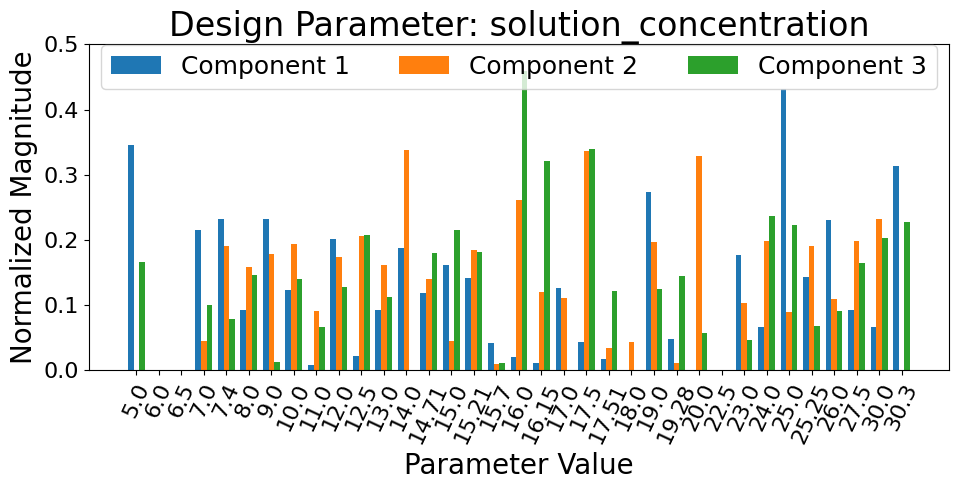

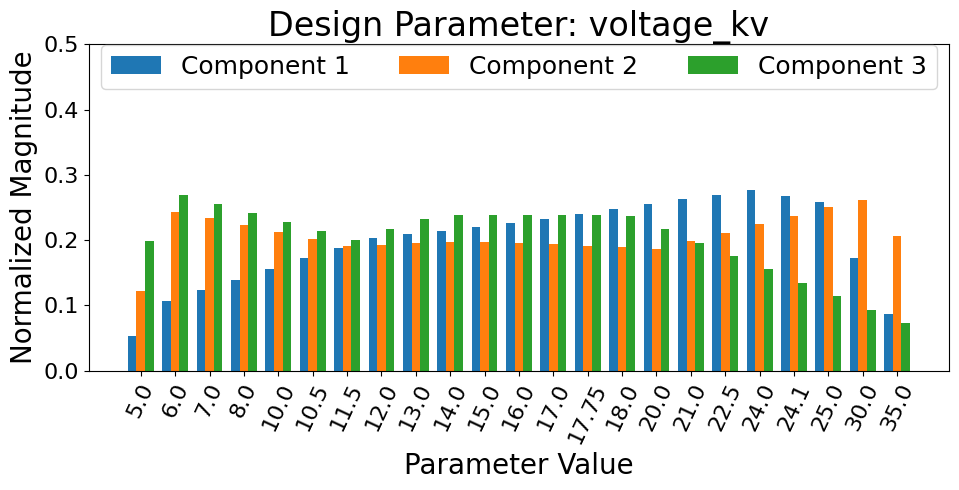

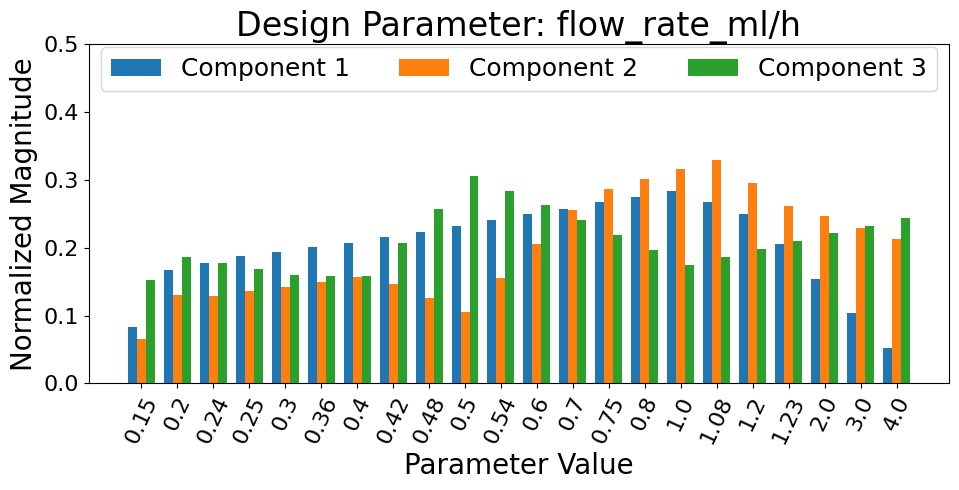

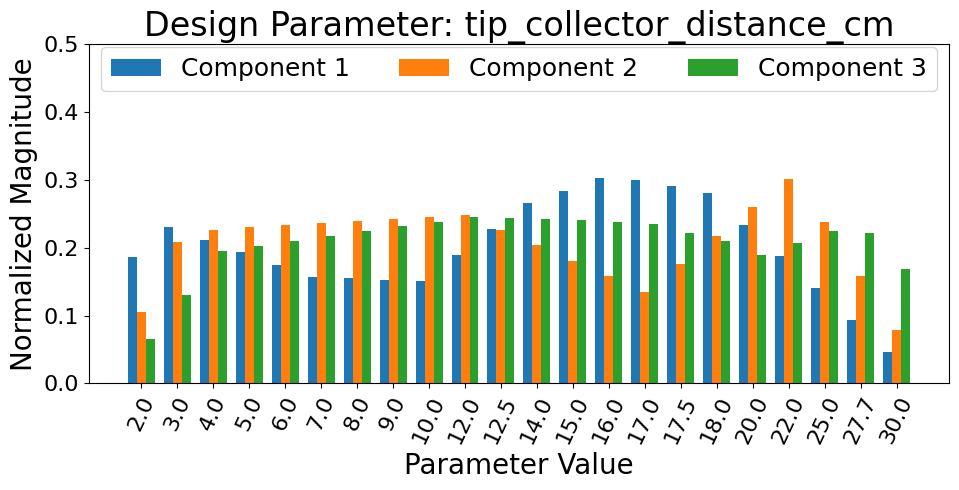

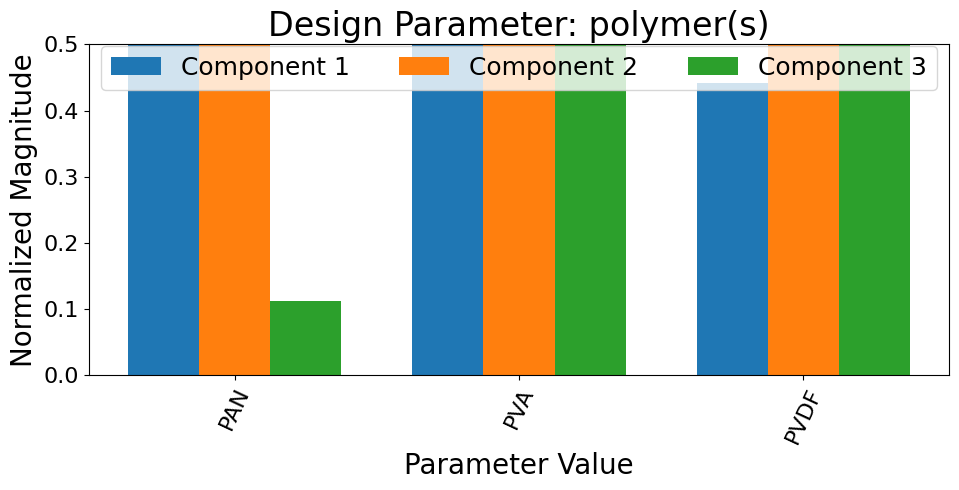

In [63]:
print(f"R² = {r2:.3f}")
scale = lambda x: x / np.linalg.norm(x, ord = 2, axis = 0)
factor_list = [model.embeds[i].weight.data for i in range(len(model.embeds))]
factor_list = [scale(factor) for factor in factor_list]
for factor_i in range(len(factor_list)): plot_factor_components(factor_i = factor_i, factor_list = factor_list, rank = rank,
                                                                highlight_bars = False)

In [14]:
for fi in range(len(tensor_features)):
    print(f"\nParameter: {tensor_features[fi]}")
    factor = factor_list[fi]
    for idx in range(factor.shape[1]):
        print(f"Component {idx+1} |", factor[:, idx].topk(2).indices.numpy(), factor[:, idx].topk(2).values.numpy().round(2))


Parameter: solution_concentration
Component 1 | [29  0] [0.43 0.35]
Component 2 | [12 20] [0.34 0.34]
Component 3 | [17 20] [0.46 0.34]

Parameter: voltage_kv
Component 1 | [18 17] [0.28 0.27]
Component 2 | [21 20] [0.26 0.25]
Component 3 | [1 2] [0.27 0.26]

Parameter: flow_rate_ml/h
Component 1 | [15 14] [0.28 0.28]
Component 2 | [16 15] [0.33 0.32]
Component 3 | [ 9 10] [0.31 0.28]

Parameter: tip_collector_distance_cm
Component 1 | [13 14] [0.3 0.3]
Component 2 | [18 17] [0.3  0.26]
Component 3 | [ 9 10] [0.25 0.24]

Parameter: polymer(s)
Component 1 | [0 1] [0.64 0.63]
Component 2 | [2 0] [0.63 0.57]
Component 3 | [2 1] [0.82 0.57]


In [15]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# def make_heatmap(factor_list, factor_i, title=None,
#                  cell_in=0.8,
#                  cbar_frac=0.06,
#                  pad=0.08):

#     A = factor_list[factor_i].t()
#     A_np = A.detach().cpu().numpy()
#     n_rows, n_cols = A_np.shape

#     heat_h = cell_in * n_rows
#     heat_w = cell_in * n_cols

#     fig_w = heat_w * (1 + cbar_frac) + 0.6
#     fig_h = heat_h + 0.8

#     fig, ax = plt.subplots(figsize=(fig_w, fig_h))

#     im = ax.imshow(
#         A_np,
#         aspect="equal",
#         interpolation="nearest",
#         # cmap="RdYlBu_r",
#         cmap = 'RdGy_r',
#         vmin=0, vmax=1
#     )

#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size=f"{int(cbar_frac*100)}%", pad=pad)

#     cbar = fig.colorbar(im, cax=cax)
#     cbar.set_label("Normalized Magnitude", fontsize=12, rotation=270, labelpad=20)

#     if dataset == 'lattice' and factor_i == len(targets)-1: ax.set_xticks(range(n_cols), labels=lattice_names.values())
#     else: ax.set_xticks(range(n_cols), labels=r_master_conv[tensor_features[factor_i]].values())

#     ax.set_yticks(range(n_rows))

#     ax.set_ylabel("Component Index", fontsize=12)

#     if title is not None: ax.set_title(title, fontsize=16)

#     fig.subplots_adjust(left=0.12, right=0.88, bottom=0.12, top=0.90)

#     plt.show()

# for factor_i in range(len(factor_list)): make_heatmap(factor_list = factor_list, factor_i = factor_i)

In [16]:
def in_all_modes(index: torch.Tensor, modes: list[int], idx_lists: list[list[int]]) -> torch.Tensor:

    assert index.ndim == 1
    assert len(modes) == len(idx_lists)

    checks = list()
    for m, idx in zip(modes, idx_lists):
        allowed = torch.as_tensor(idx, device=index.device, dtype=index.dtype)
        checks.append(torch.isin(index[m], allowed))

    return torch.stack(checks).all()

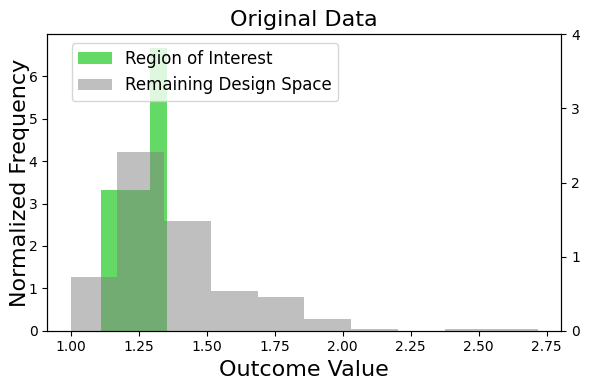

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

inv_idx = lambda x, i = 0: [idx for idx in range(sparse_tensor.shape[i]) if idx not in x]
# mode_list = [4, 2, 1]
# idx_lists = [
#     [1],
#     [13, 14, 15, 16, 17],
#     [8, 9, 10, 11, 12]
# ]

# mode_list = [0, 4]
# idx_lists = [
#     [0],
#     [1]
# ]

mode_list = [1, 2]
idx_lists = [
    [7, 8],
    [0, 1, 2]
]

# mode_list = [1, 2, 3]
# idx_lists = [
#     [1, 2, 3, 4],
#     [7, 8, 9, 10],
#     [0, 1]
# ]

# mode_list = [0, 4]
# idx_lists = [
#     [6, 12],
#     [0, 1]
# ]

sm1 = [in_all_modes(index, mode_list, idx_lists) for index in sparse_tensor.indices().t()]
sm2 = [not in_all_modes(index, mode_list, idx_lists) for index in sparse_tensor.indices().t()]

fm1 = [in_all_modes(index, mode_list, idx_lists) for index in predicted_sparse_tensor.indices().t()]
fm2 = [not in_all_modes(index, mode_list, idx_lists) for index in predicted_sparse_tensor.indices().t()]

legend_handles = None

for i in range(1):
    st = [sparse_tensor, predicted_sparse_tensor][i]
    m1 = [sm1, fm1][i]
    m2 = [sm2, fm2][i]

    ax2 = ax.twinx()

    h1 = ax.hist(
        torch.exp(st.values()[m1]),
        color='limegreen',
        alpha=0.75,
        bins=4,
        label='Region of Interest',
        density=True
    )

    h2 = ax2.hist(
        torch.exp(st.values()[m2]),
        color='gray',
        alpha=0.5,
        label='Remaining Design Space',
        zorder=0,
        density=True
    )

    ax2.set_yticks(list(range(5)))

    ax.set_title(["Original Data", "Predicted Tensor"][i], fontsize=16)
    ax.set_xlabel('Outcome Value', fontsize=16)
    ax.set_ylabel('Normalized Frequency', fontsize=16, labelpad=-1)

    # Capture handles only once
    if legend_handles is None: legend_handles = [h1[2][0], h2[2][0]]

# ---- Figure-level legend ----
fig.legend(
    legend_handles,
    ["Region of Interest", "Remaining Design Space"],
    loc="upper center",
    ncol=1,
    fontsize=12,
    frameon=True,
    bbox_to_anchor=(0.35, 0.9)
)

plt.tight_layout()
plt.show()

IndexError: list index out of range

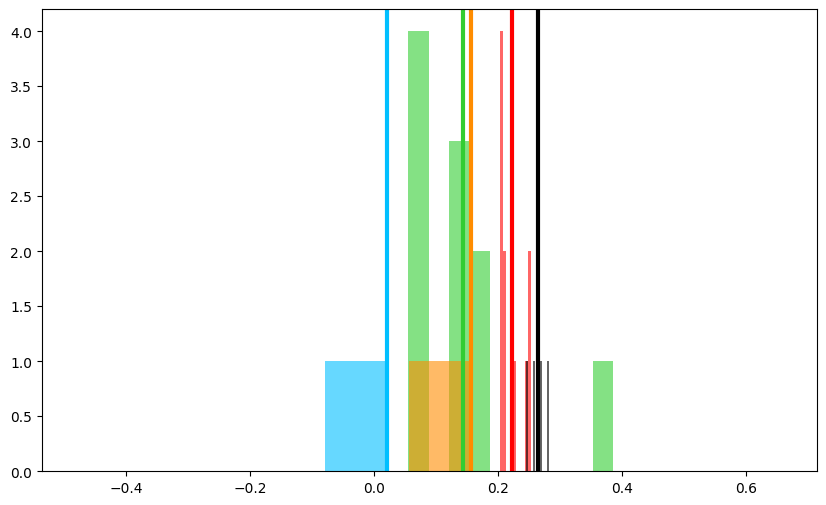

In [18]:
plt.figure(figsize = (10, 6))

colors = ['limegreen', 'deepskyblue', 'darkorange', 'red', 'black']
tensor_feature = tensor_features[0]
for i in range(len(r_master_conv[tensor_feature])):
    sub_tensor = sparse_tensor[i, ...].coalesce().values()
    plt.hist(sub_tensor, color = colors[i], alpha = 0.6, label = r_master_conv[tensor_feature][i])
    plt.axvline(sub_tensor.mean(), color = colors[i], lw = 3)

plt.legend(fontsize = 16)
plt.show()

In [37]:
def plot_bars(col = 'solution_concentration', ax = None):
    if ax is None: return None

    disp_df = pd.DataFrame()
    disp_df['col1'] = df[col]
    disp_df['col2'] = df['fiber_diameter_nm']

    agg = (
        disp_df
        .groupby("col1")["col2"]
        .agg(["mean", "std"])
        .reset_index()
    )

    ax.bar(
        np.arange(len(agg["col1"])),
        agg["mean"],
        yerr=agg["std"],
        capsize=5,
        edgecolor="black"
    )

    ax.set_xlabel(' '.join(col.split('_')), fontsize = 24)
    ax.set_ylabel("Fiber Diameter", fontsize = 24)
    ax.set_xticks(ticks = np.arange(len(agg['col1'])), 
                  labels = sorted(set(agg['col1'])), 
                  rotation = 65, ha="right")
    
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

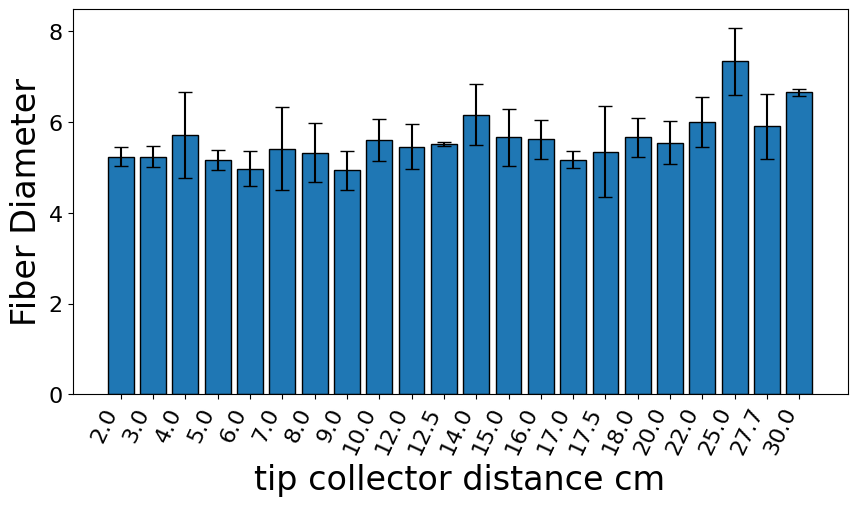

In [39]:
fig, axes = plt.subplots(1, 1, figsize = (10, 5))

# plot_bars('solution_concentration', axes)
plot_bars('tip_collector_distance_cm', axes)